# HOMEWORK 2 - TRANSFER FUNCTIONS AND SYSTEM IDENTIFICATION

This homework is about transfer functions and system identification.
There are two problems.

Make a copy of this notebook, and answer the questions.

# Preliminaries

In [1]:
import control
import controlSBML as ctl
import numpy as np
import matplotlib.pyplot as plt
import sympy
import tellurium as te
import pandas as pd
import sympy

# Helpers

In [2]:
class PlotResult(object):

    def __init__(self, times=None, yt=None, ax=None):
        self.times = times
        self.yt = yt
        self.ax = ax
        
    def __repr__(self):
        return ""

In [3]:
def plotTF(tf, times=None, is_plot=True, figsize=(5,5)):
    if times is None:
        times = np.linspace(0, 10, 100)
    _, yt = control.forced_response(tf, T=times, U=1)
    if is_plot:
        _, ax = plt.subplots(1, figsize=figsize)
        ax.plot(times, yt)
        ax.set_xlabel("time")
    else:
        ax = None
    return PlotResult(times=times, yt=yt, ax=ax)

# Tests
tf = control.TransferFunction([1], [1, 0])
plot_result = plotTF(tf, is_plot=False)
assert(isinstance(plot_result, PlotResult))
print("OK!")

OK!


In [4]:
def plotStaircaseResponse(builder, is_plot=True, **kwargs):
    """
    This function circumvents a bug in SISOTransferFunctionBuilder.plotStairCaseResponse.
    It has the same arguments and return value as the original function.
    """
    plot_result = builder.plotStaircaseResponse(is_plot=False, **kwargs)
    # Plot if requested
    if is_plot:
        times = np.array(plot_result.time_series.index)/1000
        df = pd.DataFrame(plot_result.time_series)
        df.index = times
        if "figsize" in kwargs.keys():
            figsize = kwargs["figsize"]
        else:
            figsize = (10, 10)
        legends = list(df.columns)
        fig, ax = plt.subplots(1, figsize=figsize)
        staircase_column = [c for c in df.columns if "staircase" in c][0]
        staircase_values = df[staircase_column].values
        del df[staircase_column]
        ax.plot(df)
        ax2 = ax.twinx()
        # Plot the staircase
        ax2.plot(times, staircase_values, color="red",
              linestyle="--")
        ax2.set_ylabel(staircase_column, color="red")
        ax.legend(df.columns)
    #
    return plot_result

# TESTS
if False:
    plot_response = plotStaircaseResponse(linear_builder, initial_value=2, final_value=10, num_step=5, figsize=(3,3),
                                        legend_crd=(0.5, 1), end_time=100, is_plot=True)
    assert(isinstance(plot_response.time_series, ctl.Timeseries))
    print("OK!")

# Problem 1: Constructing Laplace Transforms for reaction networks

In this problem, you will construct a Laplace transform
for the same branching network we discussed in class, but with
a different input and output.
Below is the reaction network:

\begin{eqnarray}
s_1 & \xrightarrow{k_1 s_1} s_2 \\
s_2 & \xrightarrow{k_2 s_2} s_1 \\
s_1 & \xrightarrow{k_3 s_1} s_3 \\
u & \xrightarrow{k_1 u} s_2 \\
\end{eqnarray}

The input to the system is $u$; the output is $s_2$. (In class, the output
was $s_3$.)

## 1. (5 pts) System equations

Write the system equations for this reaction network.

\begin{eqnarray}
\dot{s}_1 & = & k_2 s_2 - k_1 s_1 - k_3 s_1  \\
\dot{s}_2 & = & -k_2 s_2 + k_1 s_1 + k_1 u \\
\dot{s}_3 & = & k_3 s_1  \\
\end{eqnarray}

## 2. (5 pts) LT of system equations

Write the Laplace transforms of the system equations.

\begin{eqnarray}
s S_1(s) & = & k_2 S_2(s) - k_1 S_1 (s) - k_3 S_1 (s)  \\
s S_2 (s) & = & -k_2 S_2 (s) + k_1 S_1 (s) + k_1 U(s) \\
s S_3(s) & = & k_3 S_1 (s) \\
\end{eqnarray}

## 3. (25 pts) Calculate transfer function

Calculate the transfer function $G(s) = \frac{S_3 (s)}{S_2(s)}$.

 $G(s) = \frac{S_2 (s)}{U(s)}$.

In [5]:
#names for all variables in symbolic algebra
s3, s1, s, k1, k2, k3, s2, u = sympy.symbols("s3, s1, s, k1, k2, k3, s2, u")

expr = ((s+k2)-(k2/(s+k1+k3)))*s2 - (k1*u)
expr

-k1*u + s2*(k2 - k2/(k1 + k3 + s) + s)

In [6]:
s2 = sympy.solve(expr, s2)[0]
s2

k1*u*(k1 + k3 + s)/(k1*k2 + k1*s + k2*k3 + k2*s - k2 + k3*s + s**2)

In [7]:
print(sympy.latex(s2))

\frac{k_{1} u \left(k_{1} + k_{3} + s\right)}{k_{1} k_{2} + k_{1} s + k_{2} k_{3} + k_{2} s - k_{2} + k_{3} s + s^{2}}


### The resulting transfer function:

$G(s) = \frac{S_2(s)}{U(s)} = \frac{k_{1} \left(k_{1} + k_{3} + s\right)}{k_{1} k_{2} + k_{1} s + k_{2} k_{3} + k_{2} s - k_{2} + k_{3} s + s^{2}}$

**Comment**

1. You should get the follow. It seems that you have a small mistake in the denominator. I illustrated the issue in section 4 by changing k1, k2, k3.
$\frac{S_2(s)}{U(s)} = 
\frac{ k_{1} \left(k_{1} + k_{3} + s\right)}{k_{1} s + k_{2} k_{3} + k_{2} s + k_{3} s + s^{2}}$

## 4. (5 pts) Predict step response

Use the ``control`` package to construct the transfer function that you derived in Step 3, and simulate the transfer function. Plot the result.

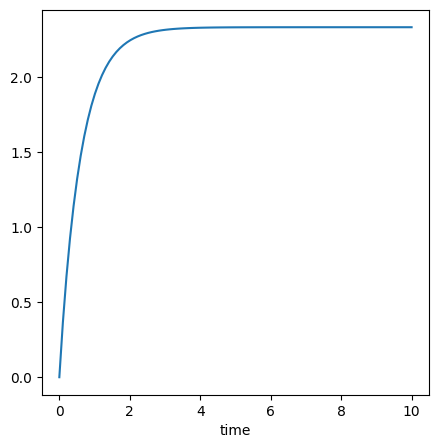

In [20]:
# Initialize constants
k1, k2, k3 = (1, 1, 1)
k1, k2, k3 = (4, 2, 3)
times = np.linspace(0, 10, 100)
# Response to input
tf = control.TransferFunction([k1, k1*k1+k1*k3],
                              [1, k1+k2+k3, k1*k2+k2*k3-k2])
_, yt = control.forced_response(tf, T=times, U=1)
# Plot the results
plot_result = plotTF(tf, is_plot=True)

### Check DC gain, k1 = 1

In [9]:
tf.dcgain()

2.0

### Increasing k1 = 3

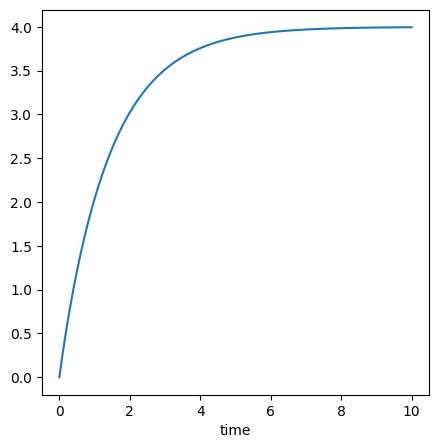

In [10]:
# Initialize constants
k1, k2, k3 = (3, 1, 1)
times = np.linspace(0, 10, 100)
# Response to input
tf = control.TransferFunction([k1, k1*k1+k1*k3],
                              [1, k1+k2+k3, k1*k2+k2*k3-k2])
_, yt = control.forced_response(tf, T=times, U=1)
# Plot the results
plot_result = plotTF(tf, is_plot=True)

### Check DC gain, k1 = 3

In [11]:
tf.dcgain()

4.0

## 5. (5 pts) Simulate in Antimony

Write an Antimony model for the original system and simulate it for a step respoinse.

Text(0.5, 0, 'time')

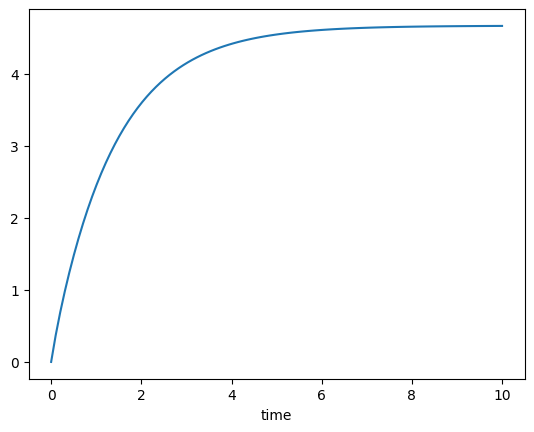

In [21]:
model = """
s1 -> s2; k1*s1
s2 -> s1; k2*s2
s1 -> s3; k3*s1
$u -> s2; k1*u

k1 = 1
k2 = 1
k3 = 1
s1 = 0
s2 = 0
s3 = 0
k1 = 4
k2 = 2
k3 = 3
$u = 1
"""
rr = te.loada(model)
data = rr.simulate(0, 10, 100)
plt.plot(data["time"], data["[s2]"])
plt.xlabel("time")

## 6. (5 pts) Analysis

1. How does the transfer function you derived and simulated in step 3 compare with the simulation results for the Antimony model in step 4?
1. How does DC gain change as $k_1$ increases?
1. Explain why the DC gain of this system is finite whereas the DC gain of the system with $s_3$ as output does not have finite DC gain.


#### Results: 
1. From comparing the Antimony and self-derived plots, both plots look the same in terms of curvature/shape and transfer function gain at the same k1,2,3 values.
2. As k1 increases, DC gain also increases
3. DC gain in this system is finite because the G(s) has an s-term in the numerator, thus G(s) ~ 1/(1+s). The limit of G(s) in this case as s-->0 is finite. 
</br> However, for system with s3 as output, G(s) was ~ 1/s^3 resulting in limit as s-->0 equals to infinity (1/0).

# Problem 2: System Identification

You will do system identification for the system you chose in the first homework.

## 1. (20 pts) Determine the operating region for you system.

Use ``SISOTransferFunctionBuilder`` to plot a staircase of the control input to your system and the measured output.
Explain why you chose the operating region you did (i.e., the value ranges of
the control input).

### Load Garde model

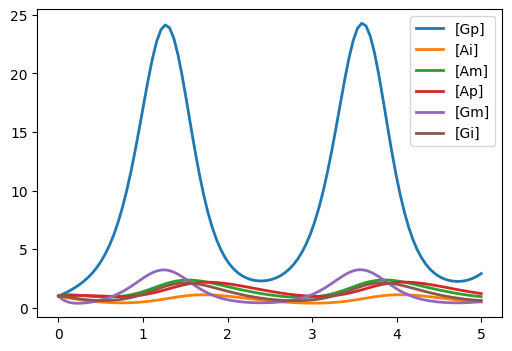

In [13]:
#Garde2020 - metabolic oscillations in Bacillus subtilis biofilms
#paper link: https://www.nature.com/articles/s41598-020-62526-6
GARDE_CTLSB = ctl.ControlSBML("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000001053.2?filename=Garde2020.xml", 
                        input_names=["Gm"], output_names=["Gi"])
GARDE_RR = GARDE_CTLSB.roadrunner
GARDE_RR.simulate(0, 5, 100)
GARDE_RR.plot()

### Setup TF builder from Garde model

In [14]:
garde_builder = GARDE_CTLSB.makeSISOTransferFunctionBuilder()
garde_builder.input_name, garde_builder.output_name

('Gm', 'Gi')

### Plot staircase

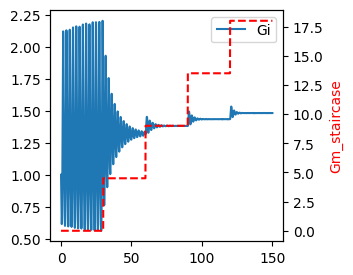

In [15]:
plotStaircaseResponse(garde_builder, initial_value=0, final_value=18, figsize=(3,3),
                                    num_step=5, legend_crd=(0.5, 1), end_time=150)

## 2. (20 pts) Find a tranfser function for your system for the operating region.

Use ``SISOTransferFunctionBuilder`` to fit a transfer function for your system.
Justify that the transfer function fits sufficiently well and does not overfit.

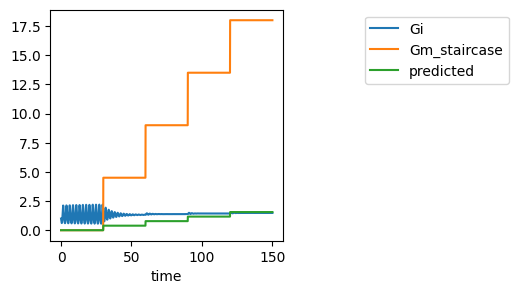

In [16]:
num_degree = 0
denom_degree = 1
fitter_result = garde_builder.fitTransferFunction(num_degree + 1, denom_degree + 1, 
                                                   final_value=18,
                                                   initial_value=0, end_time=150)
ctl.plotOneTS(fitter_result.time_series, figsize=(3,3), legend_crd=(2,1))

### Transfer function for Garde model

In [17]:
tf2 = fitter_result.transfer_function
tf2

TransferFunction(array([0.86193472]), array([1.48084862e-07, 9.96337220e+00]))

**Reasoning:** Looks like this transfer function resulted in a convergence of the oscillation (predicted result overlaps with Gi response) as input Gm is given into the system. 

## 3. (10 pts)  Analyze the transfer function.

What is the DC gain? What are the poles? What are the implications for control?

#### Part a) DC gain

In [18]:
tf2.dcgain()

0.08651034000077923

#### Part b) Poles

In [19]:
tf2.poles()

array([-67281503.86721896+0.j])

#### c) Implications for control

DC gain informs us about the output-input ratio at steady state (useful to predict the system output given a certain input). In this case DC gain is finite but small, which means output < input (we need such a high-value input in order to get a small response).

</br> Since poles are indicators of stability, the negative sign of the pole indicates that the system will eventually reach stability. The imaginary part tells us that the system generates oscillations a constant amplitude determined by the initial conditions.